<a href="https://colab.research.google.com/github/mahesh-keswani/ML-DL-Basics/blob/main/LSTM_Examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Resource: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
# Explaination: https://www.youtube.com/watch?v=9TFnjJkfqmA&list=PLyqSpQzTE6M9gCgajvQbc68Hk_JKGBAYT&index=110

# There are many types of LSTM models that can be used for each specific type of time series forecasting problem.
# In this tutorial, you will discover how to develop a suite of LSTM models for a range of standard time series forecasting problems.

In [2]:
# The models are demonstrated on small contrived time series problems intended to give the flavor of the type of time
#  series problem being addressed. The chosen configuration of the models is arbitrary and not optimized for each problem; 
#  that was not the goal.


<h1>Univariate LSTM Models</h1>

*   Data Preparation
*   Vanilla LSTM
*   Stacked LSTM
*   Bidirectional LSTM
*   CNN LSTM
*   ConvLSTM


In [3]:
# These are problems comprised of a single series of observations and a model is required to learn from the series of 
# past observations to predict the next value in the sequence.

# Before a univariate series can be modeled, it must be prepared.
# The LSTM model will learn a function that maps a sequence of past observations as input Sequence to an output observation (next time step).
# As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.
# Consider a given univariate sequence:
# [10, 20, 30, 40, 50, 60, 70, 80, 90]
# We can divide the sequence into multiple input/output patterns called samples, where "three time steps" are used as 
# input and one time step is used as output for the one-step prediction that is being learned.
# X,				y
# 10, 20, 30		40
# 20, 30, 40		50
# 30, 40, 50		60
# 


In [4]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps

		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break

		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]

		X.append(seq_x)
		y.append(seq_y)
  
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]

# choose a number of time steps
n_steps = 3

# split into samples
X, y = split_sequence(raw_seq, n_steps)

# summarize the data
for i in range(len(X)):
	print(X[i], y[i])

[10 20 30] 40
[20 30 40] 50
[30 40 50] 60
[40 50 60] 70
[50 60 70] 80
[60 70 80] 90


In [5]:
# Now that we know how to prepare a univariate series for modeling, let’s look at developing LSTM models that can 
# learn the mapping of inputs to outputs, starting with a Vanilla LSTM.

In [6]:
# VANILLA LSTM

# A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.

# We can define a Vanilla LSTM for univariate time series forecasting as follows: 
# model = Sequential()
# model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')

# Key in the definition is the shape of the input; that is what the model expects as input for each sample in terms of the number 
# of time steps and the number of features.
# We are working with a univariate series, so the number of features is one, for one variable.
# The number of time steps as input is the number we chose when preparing our dataset as an argument to the split_sequence() function.
# We almost always have multiple samples, therefore, the model will expect the input component 
# of training data to have the shape:
# [samples, timesteps, features]

# Our split_sequence() function in the previous section outputs the X with the shape [samples, timesteps], 
# so we easily reshape it to have an additional dimension for the one feature.


In [7]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))

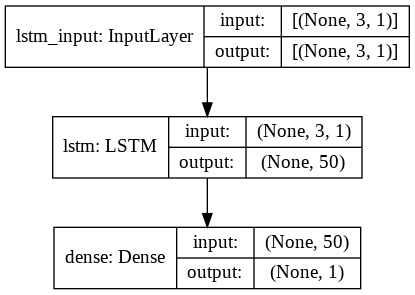

In [12]:
from tensorflow.keras.utils import plot_model

# plot model architecture
plot_model(model, show_shapes=True, to_file='vanilla_lstm.png')

In [9]:
model.compile(optimizer='adam', loss='mse')

In [10]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [11]:
# demonstrate prediction, testing it
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.11746]]


In [13]:
# We can see that the model predicts the next value in the sequence

In [14]:
# STACKED LSTM

# Multiple hidden LSTM layers can be stacked one on top of another in what is referred to as a Stacked LSTM model.

# An LSTM layer requires a three-dimensional input and LSTMs by default will produce a two-dimensional output as 
# an interpretation from the end of the sequence.
# We can address this by having the LSTM, to output a value for each time step in the input data by setting 
# the return_sequences=True argument on the layer. This allows us to have 3D output from hidden LSTM layer as input to the next.

In [15]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

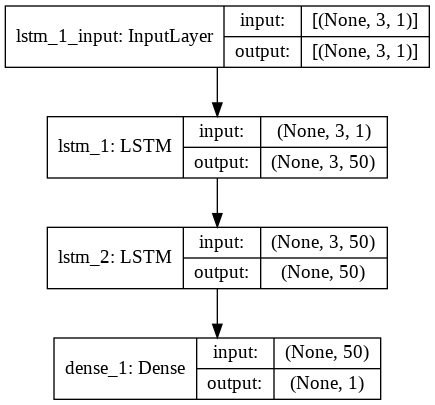

In [16]:
# plot model architecture
plot_model(model, show_shapes=True, to_file='stacked_lstm.png')

In [17]:
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [18]:
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))

yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.34577]]


In [19]:
# Running the example predicts the next value in the sequence, which we expect would be 100

In [ ]:
# BIDIRECTIONAL LSTM

# On some sequence prediction problems, it can be beneficial to allow the LSTM model to learn the input sequence both forward and backwards and
# concatenate both interpretations.
# This is called a Bidirectional LSTM.

# We can implement a Bidirectional LSTM for univariate time series forecasting by wrapping 
# the first hidden layer in a wrapper layer called Bidirectional.

# An example of defining a Bidirectional LSTM to read input from both forward as well from backward is as follows.

# define model
# model = Sequential()
# model.add(Bidirectional( LSTM(50, activation='relu'), input_shape=(n_steps, n_features) ))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')